In [ ]:
# Import libraries

In [3]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from copy import deepcopy
from tqdm import tqdm

In [4]:
%%time
data = pd.read_csv('data_for_boosting.csv')

Wall time: 15.8 s


In [5]:
data.shape

(823422, 125)

In [6]:
data.head(2)

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,datetime,target
0,2.232631,-62.084025,1.334591,76.659155,96.774194,-3.225806,0.000282,11,0.000283,0.000000,...,162.231277,0.000309,26.0,-1.148034e-15,205.975487,0.001553,0.000470,0.001506,2019-07-21 05:11:34.542501,2
1,2.108871,-91.595042,2.166042,73.108003,93.548387,-6.451613,0.000000,11,0.000309,-0.000005,...,170.244199,0.000323,27.0,-1.255613e-15,210.047304,0.001742,0.000329,0.001506,2019-07-21 05:11:47.914567,2


In [7]:
data_0_vs_other = deepcopy(data)
data_0_vs_other['target'].replace([0, 2], -1, inplace=True)
data = deepcopy(data_0_vs_other)

## Split data to train and test sets

In [8]:
data_train = data[data['datetime'] < '2019-09-25']
data_test = data[data['datetime'] >= '2019-09-25']

## Preparing train and test dataframes

In [9]:
data_train['target'] = data_train['target'].replace({-1:0})
data_test['target'] = data_test['target'].replace({-1:0})

In [10]:
# Load in the train and test datasets
train = deepcopy(data_train)
test = deepcopy(data_test)

train.head(3)

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,datetime,target
0,2.232631,-62.084025,1.334591,76.659155,96.774194,-3.225806,0.000282,11,0.000283,0.000000,...,162.231277,0.000309,26.0,-1.148034e-15,205.975487,0.001553,0.000470,0.001506,2019-07-21 05:11:34.542501,0
1,2.108871,-91.595042,2.166042,73.108003,93.548387,-6.451613,0.000000,11,0.000309,-0.000005,...,170.244199,0.000323,27.0,-1.255613e-15,210.047304,0.001742,0.000329,0.001506,2019-07-21 05:11:47.914567,0
2,1.993952,7.445769,2.978572,74.472467,96.774194,-3.225806,-0.000047,13,0.000324,0.000005,...,177.708002,0.000337,26.0,-1.263754e-15,208.077874,0.001553,0.000376,0.001789,2019-07-21 05:13:10.418727,0


In [11]:
# Feature selection
drop_elements = ['datetime']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [12]:
train.head(3)

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,value__approximate_entropy__m_2__r_0.9,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,target
0,2.232631,-62.084025,1.334591,76.659155,96.774194,-3.225806,0.000282,11,0.000283,0.000000,...,0.575476,162.231277,0.000309,26.0,-1.148034e-15,205.975487,0.001553,0.000470,0.001506,0
1,2.108871,-91.595042,2.166042,73.108003,93.548387,-6.451613,0.000000,11,0.000309,-0.000005,...,0.526774,170.244199,0.000323,27.0,-1.255613e-15,210.047304,0.001742,0.000329,0.001506,0
2,1.993952,7.445769,2.978572,74.472467,96.774194,-3.225806,-0.000047,13,0.000324,0.000005,...,0.536956,177.708002,0.000337,26.0,-1.263754e-15,208.077874,0.001553,0.000376,0.001789,0


In [13]:
test.head(3)

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,value__approximate_entropy__m_2__r_0.9,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,target
491660,4.261584,-62.285910,-2.251456,33.332722,0.000000,-100.000000,-0.000878,0,0.000883,-0.000026,...,0.583833,-176.213965,0.000225,27.0,1.238201e-15,227.420443,-0.001229,-0.002921,-0.000761,1
491661,3.992899,30.979178,-2.871133,34.674241,1.851852,-98.148148,-0.000234,0,0.000934,0.000006,...,0.597626,-169.236370,0.000199,26.0,1.888228e-15,224.472662,-0.001521,-0.003038,-0.001170,1
491662,3.779121,129.087022,-3.380602,36.156583,3.703704,-96.296296,0.000059,0,0.000896,0.000006,...,0.623886,-161.544786,0.000231,27.0,2.169235e-15,222.317221,-0.001229,-0.002630,-0.001463,1


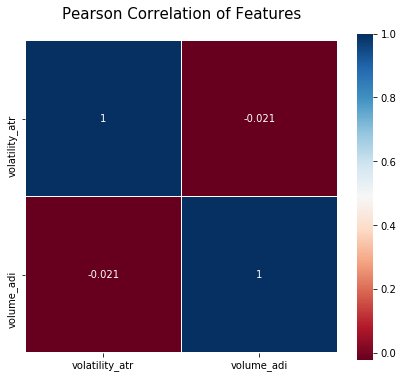

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize=(7,6))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train[['volatility_atr', 'volume_adi']].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [15]:
# g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], 
#                  vars=train[[u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], 
#                  hue='Survived', 
#                  palette = 'seismic',
#                  size=1.2,diag_kind = 'kde',
#                  diag_kws=dict(shade=True),
#                  plot_kws=dict(s=10) ) 
# g.set(xticklabels=[])

In [16]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [17]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    i = 0

    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i +=1

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [18]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [19]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [20]:
train.head(2)

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,value__approximate_entropy__m_2__r_0.9,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,target
0,2.232631,-62.084025,1.334591,76.659155,96.774194,-3.225806,0.000282,11,0.000283,0.000000,...,0.575476,162.231277,0.000309,26.0,-1.148034e-15,205.975487,0.001553,0.000470,0.001506,0
1,2.108871,-91.595042,2.166042,73.108003,93.548387,-6.451613,0.000000,11,0.000309,-0.000005,...,0.526774,170.244199,0.000323,27.0,-1.255613e-15,210.047304,0.001742,0.000329,0.001506,0


In [21]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['target'].ravel()
train = train.drop(['target'], axis=1)
test = test.drop(['target'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [22]:
test.shape

(331762, 123)

In [23]:
train.shape

(491660, 123)

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

In [72]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12570167 0.19895385 0.02900149 0.02071902 0.07226992 0.02430529
 0.10911881 0.06502244 0.06684378 0.0134174  0.27464634]
[0.11860794 0.38170499 0.02572375 0.01709375 0.05640534 0.02778839
 0.04809824 0.08479425 0.0446094  0.02125939 0.17391456]
[0.03  0.012 0.02  0.064 0.04  0.01  0.682 0.014 0.052 0.004 0.072]
[0.08343055 0.01501192 0.04583246 0.01451066 0.04773776 0.02331283
 0.17555048 0.03648205 0.11697815 0.00548942 0.43566372]


In [76]:
rf_features = [0.10474135, 
               0.21837029,
               0.04432652,
               0.02249159,
               0.05432591,
               0.02854371,
               0.07570305,
               0.01088129,
               0.24247496,
               0.13685733,
               0.06128402]

et_features = [0.12165657,
               0.37098307 ,
               0.03129623 ,
               0.01591611 ,
               0.05525811 ,
               0.028157,
               0.04589793,
               0.02030357,
               0.17289562,
               0.04853517,
               0.08910063]

ada_features = [0.028,
                0.008,
                0.012,
                0.05866667,
                0.032,
                0.008,
                0.04666667,
                0.,
                0.05733333,
                0.73866667,
                0.01066667]

gb_features = [0.06796144,
               0.03889349,
               0.07237845,
               0.02628645,
               0.11194395,
               0.04778854,
               0.05965792,
               0.02774745,
               0.07462718,
               0.4593142,
               0.01340093]

In [77]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
     'AdaBoost feature importances': ada_features,
     'Gradient Boost feature importances': gb_features
    })

In [78]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [79]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


In [80]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [81]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [82]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')


In [83]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [84]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [85]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                   'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [87]:
StackingSubmission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
